In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

torch.manual_seed(1337)
B,T,C = 4, 8, 2 # Batch size, sequence length, and number of channels
x = torch.randn(B, T, C)

In [2]:
torch.no_grad()

In [3]:
torch.manual_seed(42)

# the mat mul operation
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, dim=1, keepdim=True)
b = torch.randint(0, 10, (3, 2)).float()

# rows times columns
c = a @ b

print (a)
print (b)
print (c)

tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [4]:
weights = torch.tril(torch.ones(T, T))
weights = weights / weights.sum(1, keepdim=True)

xbow2 = weights @ x # (T, T) @ (B, T, C) -> (B, T, C)

In [5]:
xbow2

tensor([[[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]],

        [[ 1.3488, -0.1396],
         [ 0.8173,  0.4127],
         [-0.1342,  0.4395],
         [ 0.2711,  0.4774],
         [ 0.2421,  0.0694],
         [ 0.0084,  0.0020],
         [ 0.0712, -0.1128],
         [ 0.2527,  0.2149]],

        [[-0.6631, -0.2513],
         [ 0.1735, -0.0649],
         [ 0.1685,  0.3348],
         [-0.1621,  0.1765],
         [-0.2312, -0.0436],
         [-0.1015, -0.2855],
         [-0.2593, -0.1630],
         [-0.3015, -0.2293]],

        [[ 1.6455, -0.8030],
         [ 1.4985, -0.5395],
         [ 0.4954,  0.3420],
         [ 1.0623, -0.1802],
         [ 1.1401, -0.4462],
         [ 1.0870, -0.4071],
         [ 1.0430, -0.1299],
         [ 1.1138, -0.1641]]])

## timestamp

https://youtu.be/kCc8FmEb1nY?si=pq2FmeBHG37mZymE&t=3282


In [8]:
torch.tril(torch.ones(T, T))

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [ ]:
import torch.nn.functional as F

# version 3: uses softmax for normalization
tril = torch.tril(torch.ones(T, T))
weights = torch.zeros(T, T)

# with the next operation we set the upper triangular part to -inf
weights = weights.masked_fill(tril == 0, float('-inf'))  # set upper triangular to -inf
weights = F.softmax(weights, dim=-1)  # apply softmax to normalize

#the -inf is to ensure tokens from the past dont comunicati with tokens from the future
xbow3 = weights @ x  # (T, T) @ (B, T, C) -> (B, T, C)
torch.allclose(xbow2, xbow3)  # should be True, both methods yield the same result

True

In [18]:
weights

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [34]:
# self-attention
torch.manual_seed(1337)
B, T, C = 4, 8, 32 # batch size, time steps, channels
x = torch.randn(B, T, C)

head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B,T,16)
q = query(x) # (B,T,16)
wei = q @ k.transpose(-2, -1) # (B,T,16) * (B,16,T) -> (B,T,T)

tril = torch.tril(torch.ones(T, T)) # (T,T) # don't consider future tokens
wei = wei.masked_fill(tril == 0, float('-inf')) # (B,T,T) # set 0 to -inf for softmax
wei = F.softmax(wei, dim=-1) # (B,T,T) # apply softmax to sum to 1

v = value(x)    # (B,T,16)
output = wei @ v # (B,T,T) @ (B,T,16) -> (B,T,16) # attention output for each token in the sequence

In [ ]:
# Andrej Karpathy explanation
# for a token, my information is kept in vector x
# query, here is what I'm interested in
# key, here is what I have
# If you find me interesting, here is what I will communicate.

# by default, these nodes (tokens) have no way of knowing where the are in the sequence
# we can add positional encodings to the token embeddings to give them a sense of order

# for encoder attentionk, the masked_prefil is not needed, because all tokens can attend to each other


# self attention from vs cross-attention
# In this case, it is self attention, because the output of the attention mechanism moves the embedding vector of the token itself based on interaction with the other tokens in the sequence
# k, q, v are all derived from the same source, the token embeddings of the sequence itself

# in cross-attention, the k and v are derived from a different source than the q
# for example, in a language model, the k and v are derived from the token embeddings of the sequence itself, but the q is derived from the token embeddings of the sequence itself

In [ ]:
# from attention is all you need paper (2017)

# we only need to add the division by sqrt(head_size) when calculating the attention weights,

# why do we do this:
# to prevent the dot products from growing too large in magnitude
# its called "scaled dot-product attention"

k = torch.randn(B, T, head_size)
q = torch.randn(B, T, head_size)
wei = q @ k.transpose(-2, -1) # * head_size**-0.5 # (B,T,16) * (B,16,T) -> (B,T,T)

print(k.var(), q.var(), wei.var())
# variance of wei is in the order of head_size

# but if we scale it down by sqrt(head_size)
wei = wei * head_size**-0.5
print(wei.var())

# wei feeds into softmax, and softmax is sensitive to large input values
# this means softmax results in one-hot like vectors, which is not what we want

# normally distributed inputs to softmax
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

# sharpen towards the max
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]) * 8, dim=-1)

# so we scale it down by sqrt(head_size) to prevent the dot products from growing too large in magnitude

tensor(1.0010) tensor(1.0562) tensor(17.5985)
tensor(1.0999)


tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

In [3]:
from transformers import GPT2Model

model = GPT2Model.from_pretrained("gpt2")
sd_hf = model.state_dict()

for k, v in sd_hf.items():
    print(k, v.shape)

wte.weight torch.Size([50257, 768])
wpe.weight torch.Size([1024, 768])
h.0.ln_1.weight torch.Size([768])
h.0.ln_1.bias torch.Size([768])
h.0.attn.c_attn.weight torch.Size([768, 2304])
h.0.attn.c_attn.bias torch.Size([2304])
h.0.attn.c_proj.weight torch.Size([768, 768])
h.0.attn.c_proj.bias torch.Size([768])
h.0.ln_2.weight torch.Size([768])
h.0.ln_2.bias torch.Size([768])
h.0.mlp.c_fc.weight torch.Size([768, 3072])
h.0.mlp.c_fc.bias torch.Size([3072])
h.0.mlp.c_proj.weight torch.Size([3072, 768])
h.0.mlp.c_proj.bias torch.Size([768])
h.1.ln_1.weight torch.Size([768])
h.1.ln_1.bias torch.Size([768])
h.1.attn.c_attn.weight torch.Size([768, 2304])
h.1.attn.c_attn.bias torch.Size([2304])
h.1.attn.c_proj.weight torch.Size([768, 768])
h.1.attn.c_proj.bias torch.Size([768])
h.1.ln_2.weight torch.Size([768])
h.1.ln_2.bias torch.Size([768])
h.1.mlp.c_fc.weight torch.Size([768, 3072])
h.1.mlp.c_fc.bias torch.Size([3072])
h.1.mlp.c_proj.weight torch.Size([3072, 768])
h.1.mlp.c_proj.bias torch.Siz

In [19]:
#wte = word token embeddings
#wpe = word positional embeddings

sd_hf["wpe.weight"].view(-1).shape

786432 / 768
#wpe.weight torch.Size([1024, 768])

1024.0

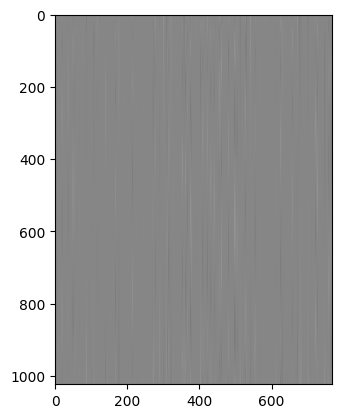

In [23]:
import matplotlib.pyplot as plt
plt.imshow(sd_hf["wpe.weight"].detach().numpy(), cmap='gray')

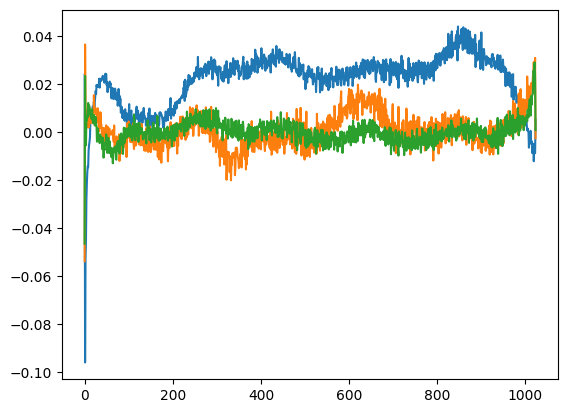

In [28]:
plt.plot(sd_hf["wpe.weight"][:, 250])
plt.plot(sd_hf["wpe.weight"][:, 200])
plt.plot(sd_hf["wpe.weight"][:, 150])

#sinusoidal positional encodings

In [30]:
from transformers import pipeline, set_seed

gen = pipeline("text-generation", model="gpt2")
set_seed(42)
gen("Hello, how are you?", max_length=30, num_return_sequences=5)

#comment: different outputs compared to Karpathy.

Device set to use mps:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=30) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[{'generated_text': "Hello, how are you? I'm sorry.\n\nThe world is a confusing place. You're not exactly sure what's wrong.\n\nThe world I've grown up in is a lot more interesting. You've made many friends, and you've been very effective in the world. But how are you?\n\nI wish I could answer that question better than you do, but I'm afraid I have no idea.\n\nYou're always the one who gets the most out of your life.\n\nIf you are to be successful, you have to know how to make it happen.\n\nSo, what's the best way to become successful? How do you help yourself to achieve that goal?\n\nI've been teaching this for years in the United States and many other countries around the world. And I think it's a really good idea.\n\nYou should be able to find someone who will help you.\n\nI'm a big believer in self-actualization, and I hope you'll be able to find someone who will help you to achieve your goals.\n\nYou know, I've heard a lot of people say that what you learn when you learn the right

In [ ]:
#quote: addition distributes gradients equally during backprop to both of its branches equally.
#for def forward() in train-gpt-2.py, the B, T are B independent sequences of T tokens where T is the max sequence length
data = open('../data/input.txt', 'r').read() # should be simple plain text file

import tiktoken
enc = tiktoken.get_encoding("gpt2")
tokens = enc.encode(data)
print(tokens[:24])


#this stacks a sequence of 24 tokens into a 4x6 batch of tokens
import torch
buf = torch.tensor(tokens[:24 + 1])
x = buf[:-1].view(4, 6) # 4 sequences of 6 tokens each
y = buf[1:].view(4, 6) # 4 sequences of 6 tokens each
print(x)
print(y)


#in this way we can create a 2d dimensional batch
# where x is the input and y is the target
# and the shape of x and y is (B, T) where B is the batch size and T is the sequence length

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13]
tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])


In [55]:
# standard deviation grows inside the residual stream
x  = torch.zeros(768)
n = 100 # 100 layers
for i in range(n):
    x += torch.randn(768) # zero-mean, 1 std

print(x.std())

# this means the std of the sum of 100 random numbers is 10

x_n  = torch.zeros(768)
n = 100 # 100 layers
for i in range(n):
    x_n += n**-0.5 * torch.randn(768) # zero-mean, 1 std

print(x_n.std())

# order of, this number can vary a bit
# the scaling factor in gpt-2 paper combats this growth

tensor(10.2925)
tensor(1.0386)


In [ ]:
# with bfloat16 instead of float32 we can speed up training from
# 19.5 TFLOPS to 312 TFLOPS, a 16x speedup.


# 1:32:16: speedups come at cost; reduced precision.
# Our accumalate input will be fp32, output will be fp32, but the weights will be TF32,
# meaning the mantissa will be 10 bits instead of 23 bits.


# why tf32?
# Its a sweet spot.


In [5]:
# we ar going to use BF16

#exponent sets the ragne
#for BF16 (Big Float 16) the range is the same as FP32 while the precision is much smaller

# initially, everyone used FP16 with Volta architecture
# But you had to use gradient scaling operations to prevent underflow

# Then Ampier series introduced BF16 training to adress this.

# we will use the pytorch .autocast operation and only surround the model step and the loss step.

# its called mixed precision training because some parts of the network, the logits are converted while others remain .dtype float32

#https://docs.pytorch.org/tutorials/intermediate/torch_compile_tutorial.html

In [ ]:
# Flash Attention


